In [1]:
# Retry VAE with optimal transport-like loss in the latent layer
# Made possible by large batch size
# Try with (how?) and without convolution

# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}


In [441]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [442]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [443]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [444]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj.T).float().cuda() for subj in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(subj.T).float().cuda() for subj in test_rest_ts]

# print(train_rest_ts_torch[0].device)
print(train_rest_ts_torch[0].shape)
print('Complete')

torch.Size([231, 264])
Complete


In [445]:
import torch

torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('Total: {:f} Reserved: {:f} Allocated: {:f} Free: {:f}'.format(t,r,a,f))

Total: 4294967296.000000 Reserved: 249561088.000000 Allocated: 236848128.000000 Free: 12712960.000000


In [523]:
nt = train_rest_ts_torch[0].shape[0]
nroi = train_rest_ts_torch[0].shape[1]
nBatch = 5
nB = nBatch*nt
nHid = 100
nLat = 60

from scipy.stats import norm
import matplotlib.pyplot as plt

def makeGaussPointsDet(nB, nLat):
    Y = np.linspace(0.0001,0.9999,nB)
    x = norm.ppf(Y)
#     y = norm.pdf(x)
#     plt.plot(x,y)
#     plt.show()
    xLat = x.reshape([-1,1])@np.ones([1,nLat])
    return torch.from_numpy(xLat).float().cuda()
    
xLatPrior = makeGaussPointsDet(nB, nLat)
# xTLatPrior = makeGaussPointsDet(nLat, nB).T

def calcOptLoss(xLat, xLatPrior):
    idcs = torch.argsort(xLat,0)
    loss = torch.sum((xLatPrior-torch.gather(xLat,0,idcs))**2)
    return loss
#     return torch.sum(torch.zeros(1).cuda())

# Try to force ROIs to be well clustered at a certain time point
def calcClusterLoss(xLat):
    m = torch.mean(xLat, 1, True)
    loss = torch.sum((xLat - m)**2)
    return loss
#     return torch.sum(torch.zeros(1).cuda())

class VAEOT(nn.Module):
    def __init__(self):
        super(VAEOT, self).__init__()
        self.en1 = nn.Linear(nroi,nHid).cuda()
        self.en2 = nn.Linear(nHid,nHid).cuda()
        self.en3 = nn.Linear(nHid,nLat).cuda()
        self.de1 = nn.Linear(nLat,nHid).cuda()
        self.de2 = nn.Linear(nHid,nHid).cuda()
        self.de3 = nn.Linear(nHid,nroi).cuda()
        
    def forward(self, x):
        x = F.relu(self.en1(x))
        x = F.relu(self.en2(x))
        z = self.en3(x)
        x = F.relu(self.de1(z))
        x = F.relu(self.de2(x))
        x = self.de3(x)
        return x, z
    
vaeot = VAEOT()
optim = torch.optim.Adam(vaeot.parameters(), lr=1e-3)

print('Complete')

Complete


In [538]:
import random

N = len(train_rest_ts_torch)
runningTot = 0
runningOpt = 0
runningCluster = 0
nEpoch = 5000
pPeriod = 200

for epoch in range(nEpoch):
    batch = []
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        subj = train_rest_ts_torch[idx]
        batch.append(subj)
    batch = torch.cat(batch)
    optim.zero_grad()
    recon, z = vaeot(batch)
    reconLoss = torch.sum((recon-batch)**2)
    optLoss = calcOptLoss(z, xLatPrior)
    clusterLoss = calcClusterLoss(z)
    loss = reconLoss + optLoss + clusterLoss
    runningCluster += clusterLoss.cpu()
    runningOpt += optLoss.cpu()
    runningTot += loss.cpu()
    loss.backward()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            runningCluster = runningCluster/pPeriod
            runningOpt = runningOpt/pPeriod
            runningTot = runningTot/pPeriod
        print('epoch {:d} clusterLoss={:f} optLoss={:f} loss={:f}'.format(epoch, clusterLoss, runningOpt, runningTot))
        runningCluster = 0
        runningOpt = 0
        runningTot = 0

print('Finished training')

epoch 0 clusterLoss=924.275269 optLoss=344.995178 loss=132405.609375
epoch 200 clusterLoss=815.657837 optLoss=351.488464 loss=113820.320312
epoch 400 clusterLoss=797.075806 optLoss=326.291504 loss=114473.039062
epoch 600 clusterLoss=825.149109 optLoss=319.456909 loss=114606.773438
epoch 800 clusterLoss=859.280273 optLoss=334.373444 loss=115119.179688
epoch 1000 clusterLoss=815.783630 optLoss=333.222931 loss=113259.078125
epoch 1200 clusterLoss=943.364929 optLoss=324.318665 loss=112795.078125
epoch 1400 clusterLoss=756.780273 optLoss=324.372986 loss=111361.726562
epoch 1600 clusterLoss=784.597534 optLoss=331.429230 loss=112471.953125
epoch 1800 clusterLoss=792.219971 optLoss=331.807312 loss=111045.140625
epoch 2000 clusterLoss=810.138184 optLoss=338.330627 loss=110767.851562
epoch 2200 clusterLoss=759.427551 optLoss=334.011871 loss=111183.406250
epoch 2400 clusterLoss=758.222412 optLoss=322.543579 loss=110275.859375
epoch 2600 clusterLoss=719.776001 optLoss=317.845886 loss=109555.687500

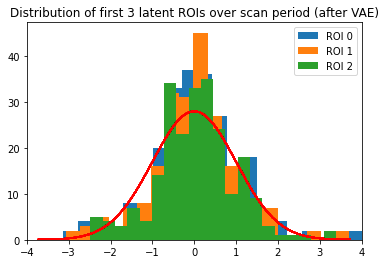

In [539]:
subj = train_rest_ts_torch[0]
x, z = vaeot(subj)
z = z.cpu().detach().numpy()
prior = xLatPrior.cpu().detach().numpy()
# idcs = torch.argsort(z)
# zSort = torch.gather(z,1,idcs)
plt.hist(z[:,0], 20, label='ROI 0')
plt.hist(z[:,1], 20, label='ROI 1')
plt.hist(z[:,30], 20, label='ROI 2')
plt.plot(prior, 70*norm.pdf(prior), color='red')
plt.xlim([-4,4])
plt.legend()
plt.title('Distribution of first 3 latent ROIs over scan period (after VAE)')
plt.show()

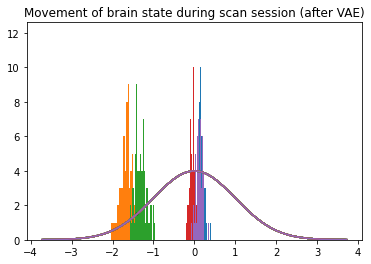

In [540]:
for i in range(100,105):
    plt.hist(z[i,:], 20)
plt.plot(prior, 10*norm.pdf(prior))
plt.title('Movement of brain state during scan session (after VAE)')
plt.show()

In [219]:
print(z[5,:])

[-0.28693557 -0.23070024 -0.29121995 -0.26886922 -0.22450858 -0.22054027
 -0.33936617 -0.13710739 -0.3940301  -0.284985   -0.12870732 -0.33628446
 -0.2009156  -0.08606857 -0.22219397 -0.28014398 -0.29918677 -0.11134481
 -0.21218061 -0.16567083 -0.20339419 -0.22590733 -0.13721488 -0.15766323
 -0.10696881 -0.04797342 -0.02330992 -0.13765076 -0.2235625  -0.1963327
 -0.17720754 -0.21894322 -0.08574609 -0.20422825 -0.2249323  -0.18525141
 -0.21416306 -0.17885174 -0.07661259 -0.2146323  -0.2325843  -0.318533
 -0.2606396  -0.09675867 -0.1334992  -0.3158305  -0.11243689 -0.2639306
 -0.2019357  -0.24208798 -0.14911935 -0.3406924  -0.31752288 -0.1672651
 -0.07047746 -0.150229   -0.22227255 -0.28103274 -0.15592673 -0.33083934]


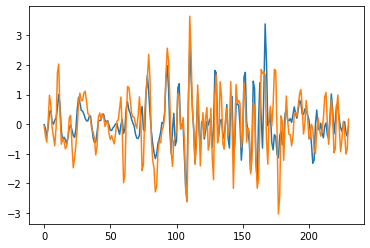

In [541]:
o = train_rest_ts[0].T
x = x.cpu().detach().numpy()
plt.plot(x[:,0])
plt.plot(o[:,0])
plt.show()

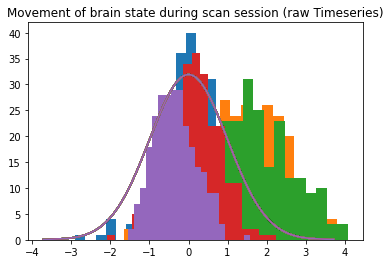

In [542]:
for i in range(100,105):
    plt.hist(o[i,:], 20)
plt.plot(prior, 80*norm.pdf(prior))
plt.title('Movement of brain state during scan session (raw Timeseries)')
plt.show()

In [543]:
train_rest_z = []
test_rest_z = []

for subj in train_rest_ts_torch:
    x,z = vaeot(subj)
    z = z.cpu().detach().numpy()
    train_rest_z.append(z)
    
for subj in test_rest_ts_torch:
    x,z = vaeot(subj)
    z = z.cpu().detach().numpy()
    test_rest_z.append(z)

# Calculate the Pearson correlation coefficient
# Assumes normalized to mean=0 and std=1
def pearsonr(ts):
    nt = ts.shape[0]
    return ts.T@ts/nt

train_rest_z_pr = []
test_rest_z_pr = []

for z in train_rest_z:
    train_rest_z_pr.append(pearsonr(z))
    
for z in test_rest_z:
    test_rest_z_pr.append(pearsonr(z))
    
print('Complete')

Complete


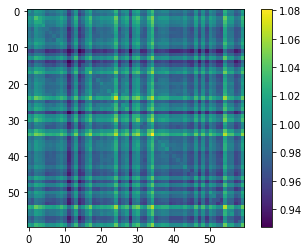

In [544]:
plt.imshow(test_rest_z_pr[100])
plt.colorbar()
plt.show()

In [227]:
print(y_train.shape)
print(y_test.shape)

(466, 1)
(156, 1)


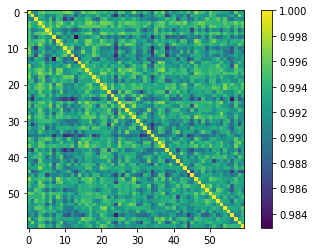

In [551]:
train_rest_z_pr = [np.corrcoef(subj.T) for subj in train_rest_z]
test_rest_z_pr = [np.corrcoef(subj.T) for subj in test_rest_z]

plt.imshow(train_rest_z_pr[0])
plt.colorbar()
plt.show()

In [552]:
# After VAEOT

Xtrain = np.zeros([len(train_rest_z_pr), nLat*nLat])
Xtest = np.zeros([len(test_rest_z_pr), nLat*nLat])

for i in range(len(train_rest_z_pr)):
    Xtrain[i,:] = train_rest_z_pr[i].flatten()
    
for i in range(len(test_rest_z_pr)):
    Xtest[i,:] = test_rest_z_pr[i].flatten()
    
print('Complete')

Complete


In [546]:
# Before VAEOT, raw Pearson

Xtrain = np.zeros([len(train_rest_ts), 264*264])
Xtest = np.zeros([len(test_rest_ts), 264*264])

for i in range(len(train_rest_ts)):
    Xtrain[i,:] = pearsonr(train_rest_ts[i].T).flatten()
    
for i in range(len(test_rest_ts)):
    Xtest[i,:] = pearsonr(test_rest_ts[i].T).flatten()
    
print('Complete')

Complete


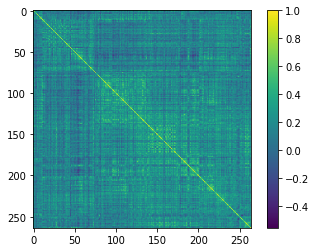

In [462]:
plt.imshow(pearsonr(train_rest_ts[i].T))
plt.colorbar()
plt.show()

In [553]:
yTrain = y_train.flatten()
yTest = y_test.flatten()

w, r, _, _ = np.linalg.lstsq(Xtrain, yTrain, rcond=None)

print('Complete')

Complete


[[1.         0.41663453]
 [0.41663453 1.        ]]
3.816698915163466
2.7658329270913513


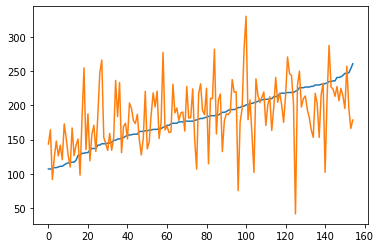

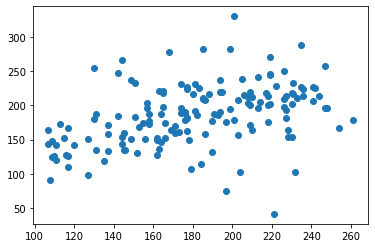

In [554]:
y = yTest
X = Xtest
yPred = X@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

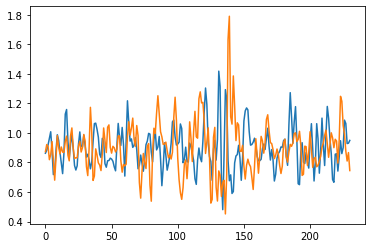

In [520]:
# Change of brian state in time

for i in range(0,2):
    subj = test_rest_z[i]
    peak = np.sum(subj, axis=1)/subj.shape[1]
    plt.plot(peak)
    
plt.show()